In [1]:
import pandas as pd
import plotly.express as px
import os
import numpy as np

if not os.path.exists("plots"):
    os.mkdir("plots")

In [2]:
## Power results
df_power = pd.read_csv("power_results.csv")
df_power = df_power.drop(columns="Build")
df_power[["scene", "api", "brdf"]] = df_power["Config"].str.split(pat="_", expand=True)

## Performance results
df = pd.read_csv("performance_results.csv")
df["Capture time [s]"] = df["Capture time [s]"].str.replace("s", "").astype(float)
df["fps"] = df["Frames"] / df["Capture time [s]"]
df[["scene", "api", "brdf", "workload"]] = df["Config"].str.split(pat="_", expand=True)
df["Config"] = df["scene"] + "_" + df["api"] + "_" + df["brdf"]
df["R/W [MB/frame]"] = df["Read [MB/frame]"] + df["Write [MB/frame]"]

df['prefix_value'] = df['Prefix'].apply(lambda x: 1e6 if x=="M" else 1e9)
df["Cycles / frame"] = df["Cycles/ 10 frames [Prefix-Cycles]"] / 10 * df["prefix_value"]

# Filter out bad data
df_filtered = df.loc[df["Comment"] != "bad sample"]
df_filtered = df_filtered.loc[~((df_filtered["Config"] == "lucy_vk_ue4") & (df_filtered["Workload"] == 10) & (df_filtered["Cycles/ 10 frames [Prefix-Cycles]"] < 150))]
df = df_filtered
df = df.drop(columns=["Read [MB/s]", "Write [MB/s]", "workload", "Cycles/ 10 frames [Prefix-Cycles]", "Comment"])
#df

In [3]:
#df_power

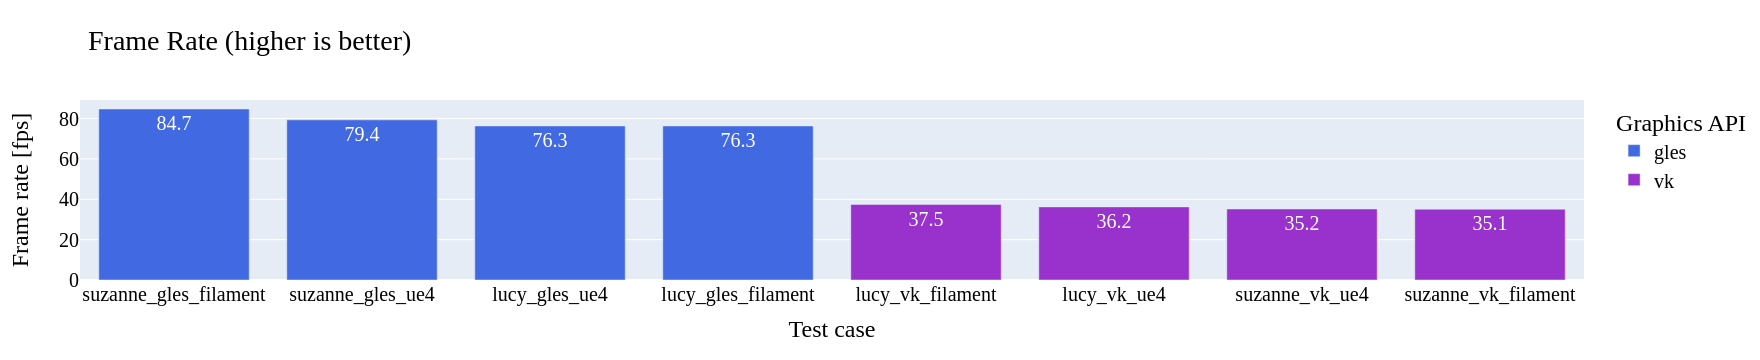

\begin{tabular}{lllllr}
\toprule
scene & api & brdf & Config & Workload & fps \\
\midrule
lucy & gles & filament & lucy_gles_filament & 10 & 76.3 \\
lucy & gles & ue4 & lucy_gles_ue4 & 10 & 76.3 \\
lucy & vk & filament & lucy_vk_filament & 10 & 37.5 \\
lucy & vk & ue4 & lucy_vk_ue4 & 10 & 36.2 \\
suzanne & gles & filament & suzanne_gles_filament & 10 & 84.7 \\
suzanne & gles & ue4 & suzanne_gles_ue4 & 10 & 79.4 \\
suzanne & vk & filament & suzanne_vk_filament & 10 & 35.1 \\
suzanne & vk & ue4 & suzanne_vk_ue4 & 10 & 35.2 \\
\bottomrule
\end{tabular}



scene   api      brdf                 Config Workload        fps
0     lucy  gles  filament     lucy_gles_filament       10  76.335878
1     lucy  gles       ue4          lucy_gles_ue4       10  76.335878
2     lucy    vk  filament       lucy_vk_filament       10  37.453184
3     lucy    vk       ue4            lucy_vk_ue4       10  36.231884
4  suzanne  gles  filament  suzanne_gles_filament       10  84.745763
5  suzanne  gles       ue4       suzanne_gles_ue4       10  79.365079
6  suzanne    vk  filament    suzanne_vk_filament       10  35.087719
7  suzanne    vk       ue4         suzanne_vk_ue4       10  35.211268

In [4]:
### Frame-rate
df_10x = df.pivot_table(
    index = ["scene", "api", "brdf", "Config"],
    values = "fps",
    columns="Workload",
    aggfunc="max"
).reset_index()

df_10x = df_10x.melt(
    id_vars=["scene", "api", "brdf", "Config"],
    value_name="fps",
)

df_fps_10x = df_10x.loc[df_10x["Workload"] == 10]

fig = px.bar(df_fps_10x, x = "Config" , y = "fps", color = "api", text_auto=".3s",
             title='Frame Rate (higher is better)',
            color_discrete_map={
                'gles': 'royalblue',
                'vk': 'DarkOrchid',
            },
            labels = {
                "fps": "Frame rate [fps]",
                "api": "Graphics API",
                "Config": "Test case", 
            },
)
fig.update_layout(xaxis={'categoryorder':'total descending'})
#fig.update_layout(title='<b>Frame Rate (higher is better)</b>')

fig.update_layout(
    font=dict(
        family="FiraCode, Bold",
        size=20,  # Set the font size here
        color="black"
    )
)

fig.write_image("plots/fps.png", scale=3)
fig.show()


print(df_fps_10x.to_latex(index=False,
      formatters={"name": str.upper},
      float_format="{:.1f}".format),
)

df_fps_10x

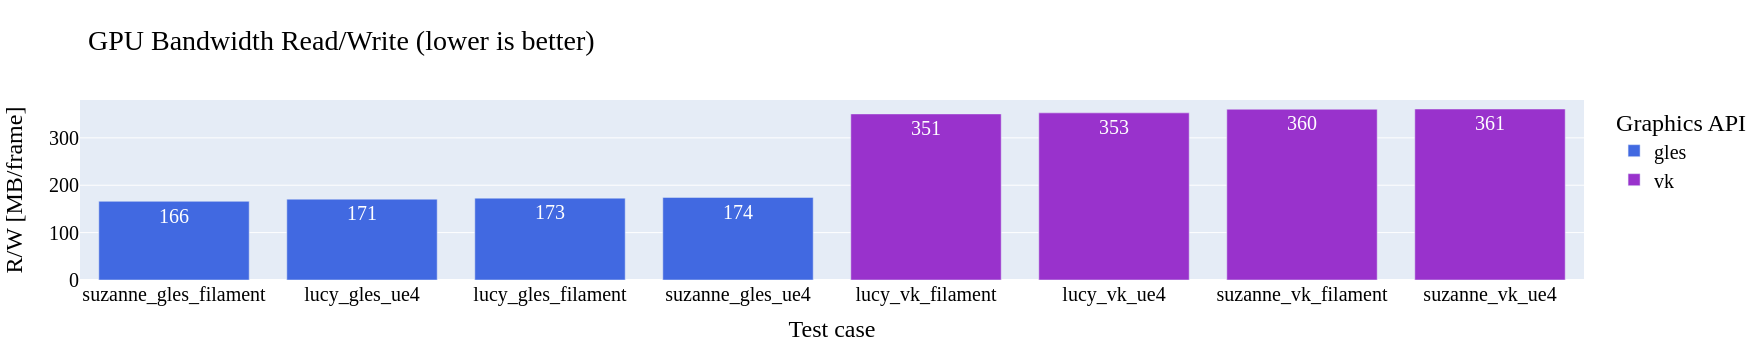

scene   api      brdf                 Config Workload   
0     lucy  gles  filament     lucy_gles_filament       10  \
1  suzanne  gles  filament  suzanne_gles_filament       10   
2     lucy  gles       ue4          lucy_gles_ue4       10   
3  suzanne  gles       ue4       suzanne_gles_ue4       10   
4     lucy    vk  filament       lucy_vk_filament       10   
5  suzanne    vk  filament    suzanne_vk_filament       10   
6     lucy    vk       ue4            lucy_vk_ue4       10   
7  suzanne    vk       ue4         suzanne_vk_ue4       10   

   bandwidth [MB/frame]  
0              172.8009  
1              166.0653  
2              170.6037  
3              174.2990  
4              350.5456  
5              360.4074  
6              352.7431  
7              360.9110

In [5]:
### Bandwidth

df_bw_10x = df.pivot_table(
    index = ["api", "brdf", "scene", "Config"],
    values = "R/W [MB/frame]",
    columns="Workload",
    aggfunc="min"
).reset_index()

df_bw_10x = df_bw_10x.melt(
    id_vars=["scene", "api", "brdf", "Config"],
    value_name="bandwidth [MB/frame]",
)
df_bw_10x = df_bw_10x.loc[df_10x["Workload"] == 10]


fig = px.bar(df_bw_10x, x = "Config" , y = "bandwidth [MB/frame]", color = "api", text_auto=".3s",
            title="GPU Bandwidth Read/Write (lower is better)",
            color_discrete_map={
                'gles': 'royalblue',
                'vk': 'DarkOrchid',
            },
            labels = {
                "bandwidth [MB/frame]": "R/W [MB/frame]",
                "Config": "Test case",
                "api": "Graphics API",
            },
)
fig.update_layout(xaxis={'categoryorder':'total ascending'})
fig.update_layout(
    font=dict(
        family="FiraCode, Bold",
        size=20,  # Set the font size here
        color="black"
    )
)
fig.write_image("plots/bandwidth.png", scale=3)
fig.show()

df_bw_10x

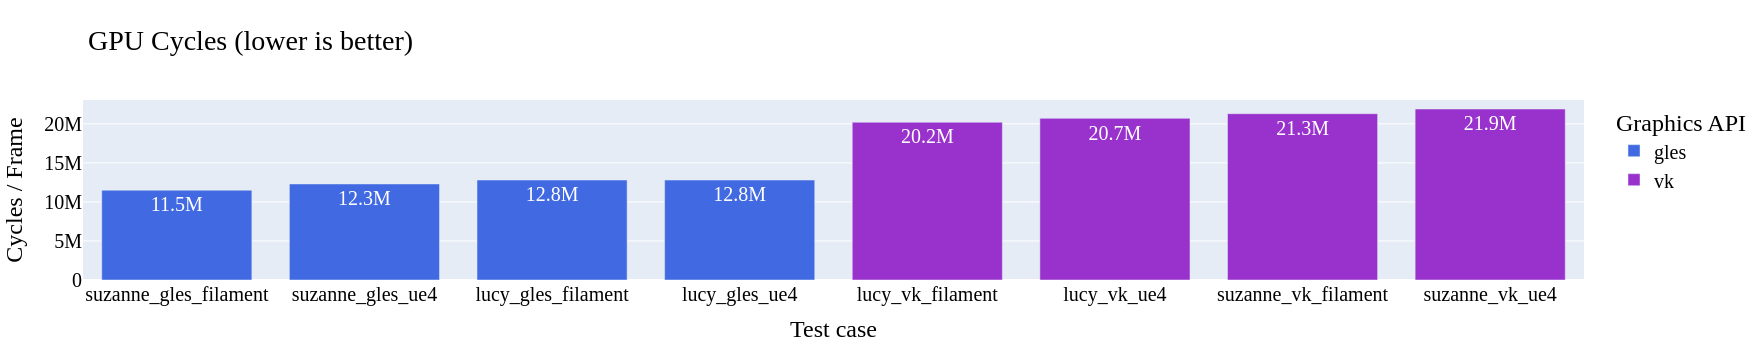

scene   api      brdf                 Config Workload  Cycles / frame
0     lucy  gles  filament     lucy_gles_filament       10      12800000.0
1  suzanne  gles  filament  suzanne_gles_filament       10      11500000.0
2     lucy  gles       ue4          lucy_gles_ue4       10      12800000.0
3  suzanne  gles       ue4       suzanne_gles_ue4       10      12300000.0
4     lucy    vk  filament       lucy_vk_filament       10      20200000.0
5  suzanne    vk  filament    suzanne_vk_filament       10      21300000.0
6     lucy    vk       ue4            lucy_vk_ue4       10      20700000.0
7  suzanne    vk       ue4         suzanne_vk_ue4       10      21900000.0

In [6]:
### Cycles

df_cycles_10x = df.pivot_table(
    index = ["api", "brdf", "scene", "Config"],
    values = "Cycles / frame",
    columns="Workload",
    aggfunc="min"
).reset_index()

df_cycles_10x = df_cycles_10x.melt(
    id_vars=["scene", "api", "brdf", "Config"],
    value_name="Cycles / frame",
)

df_cycles_10x = df_cycles_10x.loc[df_10x["Workload"] == 10]


fig = px.bar(df_cycles_10x, x = "Config", y = "Cycles / frame", color = "api", 
             color_discrete_map={
                'gles': 'royalblue',
                'vk': 'DarkOrchid',
            },
            text_auto=".3s",
            title="GPU Cycles (lower is better)",
            labels = {
                "Cycles / frame": "Cycles / Frame",
                "Config": "Test case",
                "api": "Graphics API",
            },
)
fig.update_layout(xaxis={'categoryorder':'total ascending'}) 
fig.update_layout(
    font=dict(
        family="FiraCode, Bold",
        size=20,  # Set the font size here
        color="black"
    )
)
fig.write_image("plots/cycles.png", scale=3)
fig.show()
df_cycles_10x

In [33]:
### Power
df_power_min = df_power.pivot_table(
    index = ["api", "brdf", "scene", "Config"],
    values = "Power [W]",
    columns="Workload",
    aggfunc="min"
).reset_index()



df_power_min = df_power_min.melt(
    id_vars=["scene", "api", "brdf", "Config"],
    value_name="Power [W]",
)


fig = px.line(df_power_min, x = "Config" , y = "Power [W]",  color = "Workload", 
             #barmode="group",
             #text_auto=".3s",
              text="Power [W]",
             title="Power workload comparison",
            labels = {
                "bandwidth [MB/frame]": "Bandwidth [MB / frame]",
                "Config": "Test case",
                "api": "Graphics API",
            },
)
#fig.update_layout(xaxis={'categoryorder':'total descending'}) 
fig.write_image("plots/power_workload_comparison.png", scale=3)
fig.update_traces(textposition="top center")
fig.show()


df_power_min_10x = df_power_min.loc[df_power_min["Workload"] == 10]


fig = px.bar(df_power_min_10x, x = "Config" , y = "Power [W]",  color = "api",
             color_discrete_map={
                'gles': 'royalblue',
                'vk': 'DarkOrchid',
            },
            text_auto=".3s",
            title="Power (lower is better)",
            labels = {
                "bandwidth [MB/frame]": "Bandwidth [MB / frame]",
                "Config": "Test case",
                "api": "Graphics API",
            },
)
fig.update_layout(xaxis={'categoryorder':'total descending'})
fig.update_layout(
    font=dict(
        family="FiraCode, Bold",
        size=20,  # Set the font size here
        color="black"
    )
)
fig.write_image("plots/power.png", scale=3)
fig.show()

In [66]:
df_best_10x = pd.merge(df_fps_10x, df_bw_10x, how ='left').merge(df_cycles_10x, how='left').merge(df_power_min_10x, how ='left')
df_best_10x["Efficiency [FPS/W]"] = df_best_10x["fps"] / df_best_10x["Power [W]"]
df_best_10x["Frame Energy [mJ/frame]"] =   (df_best_10x["Power [W]"] / df_best_10x["fps"]) * 1000

df_performance_report = df_best_10x

df_best_10x = df_best_10x.melt(
 id_vars=["Config", "scene", "api", "brdf", "Workload"],   
)
df_best_10x

Config    scene   api      brdf Workload   
0      lucy_gles_filament     lucy  gles  filament       10  \
1           lucy_gles_ue4     lucy  gles       ue4       10   
2        lucy_vk_filament     lucy    vk  filament       10   
3             lucy_vk_ue4     lucy    vk       ue4       10   
4   suzanne_gles_filament  suzanne  gles  filament       10   
5        suzanne_gles_ue4  suzanne  gles       ue4       10   
6     suzanne_vk_filament  suzanne    vk  filament       10   
7          suzanne_vk_ue4  suzanne    vk       ue4       10   
8      lucy_gles_filament     lucy  gles  filament       10   
9           lucy_gles_ue4     lucy  gles       ue4       10   
10       lucy_vk_filament     lucy    vk  filament       10   
11            lucy_vk_ue4     lucy    vk       ue4       10   
12  suzanne_gles_filament  suzanne  gles  filament       10   
13       suzanne_gles_ue4  suzanne  gles       ue4       10   
14    suzanne_vk_filament  suzanne    vk  filament       10   
15         suzanne_vk_ue4  suzanne    vk       ue4       10   
16     lucy_gles_filament     lucy  gles  filament       10   
17          lucy_gles_ue4     lucy  gles       ue4       10   
18       lucy_vk_filament     lucy    vk  filament       10   
19            lucy_vk_ue4     lucy    vk       ue4       10   
20  suzanne_gles_filament  suzanne  gles  filament       10   
21       suzanne_gles_ue4  suzanne  gles       ue4       10   
22    suzanne_vk_filament  suzanne    vk  filament       10   
23         suzanne_vk_ue4  suzanne    vk       ue4       10   
24     lucy_gles_filament     lucy  gles  filament       10   
25          lucy_gles_ue4     lucy  gles       ue4       10   
26       lucy_vk_filament     lucy    vk  filament       10   
27            lucy_vk_ue4     lucy    vk       ue4       10   
28  suzanne_gles_filament  suzanne  gles  filament       10   
29       suzanne_gles_ue4  suzanne  gles       ue4       10   
30    suzanne_vk_filament  suzanne    vk  filament       10   
31         suzanne_vk_ue4  suzanne    vk       ue4       10   
32     lucy_gles_filament     lucy  gles  filament       10   
33          lucy_gles_ue4     lucy  gles       ue4       10   
34       lucy_vk_filament     lucy    vk  filament       10   
35            lucy_vk_ue4     lucy    vk       ue4       10   
36  suzanne_gles_filament  suzanne  gles  filament       10   
37       suzanne_gles_ue4  suzanne  gles       ue4       10   
38    suzanne_vk_filament  suzanne    vk  filament       10   
39         suzanne_vk_ue4  suzanne    vk       ue4       10   
40     lucy_gles_filament     lucy  gles  filament       10   
41          lucy_gles_ue4     lucy  gles       ue4       10   
42       lucy_vk_filament     lucy    vk  filament       10   
43            lucy_vk_ue4     lucy    vk       ue4       10   
44  suzanne_gles_filament  suzanne  gles  filament       10   
45       suzanne_gles_ue4  suzanne  gles       ue4       10   
46    suzanne_vk_filament  suzanne    vk  filament       10   
47         suzanne_vk_ue4  suzanne    vk       ue4       10   

                   variable         value  
0                       fps  7.633588e+01  
1                       fps  7.633588e+01  
2                       fps  3.745318e+01  
3                       fps  3.623188e+01  
4                       fps  8.474576e+01  
5                       fps  7.936508e+01  
6                       fps  3.508772e+01  
7                       fps  3.521127e+01  
8      bandwidth [MB/frame]  1.728009e+02  
9      bandwidth [MB/frame]  1.706037e+02  
10     bandwidth [MB/frame]  3.505456e+02  
11     bandwidth [MB/frame]  3.527431e+02  
12     bandwidth [MB/frame]  1.660653e+02  
13     bandwidth [MB/frame]  1.742990e+02  
14     bandwidth [MB/frame]  3.604074e+02  
15     bandwidth [MB/frame]  3.609110e+02  
16           Cycles / frame  1.280000e+07  
17           Cycles / frame  1.280000e+07  
18           Cycles / frame  2.020000e+07  
19           Cycles / frame  2.070000e+07  
20     

In [67]:
best_efficiency = df_best_10x.loc[df_best_10x["variable"] == "Efficiency [FPS/W]"]
fig = px.bar(best_efficiency, x="Config", y="value", color="api",
            text_auto=".3s",
            title="Frame Efficiency (higher is better)",
            color_discrete_map={
                'gles': 'royalblue',
                'vk': 'DarkOrchid',
            },
            labels = {
                "value": "Efficiency [FPS / W]",
                "Config": "Test case",
                "api": "Graphics API",
            },
)
fig.update_layout(xaxis={'categoryorder':'total descending'})
fig.update_layout(
    font=dict(
        family="FiraCode, Bold",
        size=20,  # Set the font size here
        color="black"
    )
)
fig.write_image("plots/efficiency.png", scale=3)
fig.show()


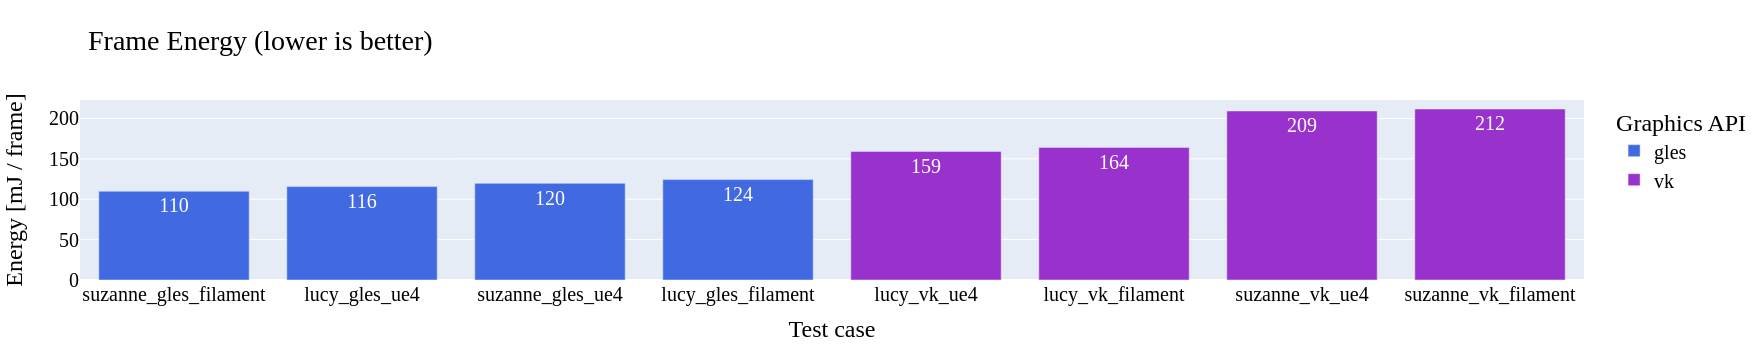

In [68]:
best_energy = df_best_10x.loc[df_best_10x["variable"] == "Frame Energy [mJ/frame]"]
fig = px.bar(best_energy, x="Config", y="value", color="api",
            text_auto=".3s",
            title="Frame Energy (lower is better)",
            color_discrete_map={
                'gles': 'royalblue',
                'vk': 'DarkOrchid',
            },
            labels = {
                "value": "Energy [mJ / frame]",
                "Config": "Test case",
                "api": "Graphics API",
            },
)
fig.update_layout(xaxis={'categoryorder':'total ascending'})
fig.update_layout(
    font=dict(
        family="FiraCode, Bold",
        size=20,  # Set the font size here
        color="black"
    )
)
fig.write_image("plots/energy.png", scale=3)
fig.show()


In [70]:


df_performance_report = df_performance_report.drop(columns=["Config", "Workload"])
df_performance_report = df_performance_report.rename(columns={"scene": "Scene", "api":"API", "brdf":"BRDF", "fps":"Frame Rate [fps]", "bandwidth [MB/frame]":"BW [MB/frame]", "Frame Energy [mJ/frame]":"Energy [mJ/frame]", "Efficiency [FPS/W]":"Efficiency [fps/W]"})

print(df_performance_report.to_latex(index=False,
      formatters={"name": str.upper},
      float_format="{:.1f}".format),
)

df_performance_report

\begin{tabular}{lllrrrrrr}
\toprule
Scene & API & BRDF & Frame Rate [fps] & BW [MB/frame] & Cycles / frame & Power [W] & Efficiency [fps/W] & Energy [mJ/frame] \\
\midrule
lucy & gles & filament & 76.3 & 172.8 & 12800000.0 & 9.5 & 8.0 & 124.3 \\
lucy & gles & ue4 & 76.3 & 170.6 & 12800000.0 & 8.8 & 8.6 & 115.7 \\
lucy & vk & filament & 37.5 & 350.5 & 20200000.0 & 6.2 & 6.1 & 164.2 \\
lucy & vk & ue4 & 36.2 & 352.7 & 20700000.0 & 5.8 & 6.3 & 159.3 \\
suzanne & gles & filament & 84.7 & 166.1 & 11500000.0 & 9.3 & 9.1 & 110.0 \\
suzanne & gles & ue4 & 79.4 & 174.3 & 12300000.0 & 9.5 & 8.4 & 119.7 \\
suzanne & vk & filament & 35.1 & 360.4 & 21300000.0 & 7.4 & 4.7 & 211.8 \\
suzanne & vk & ue4 & 35.2 & 360.9 & 21900000.0 & 7.4 & 4.8 & 209.3 \\
\bottomrule
\end{tabular}



Scene   API      BRDF  Frame Rate [fps]  BW [MB/frame]  Cycles / frame   
0     lucy  gles  filament         76.335878       172.8009      12800000.0  \
1     lucy  gles       ue4         76.335878       170.6037      12800000.0   
2     lucy    vk  filament         37.453184       350.5456      20200000.0   
3     lucy    vk       ue4         36.231884       352.7431      20700000.0   
4  suzanne  gles  filament         84.745763       166.0653      11500000.0   
5  suzanne  gles       ue4         79.365079       174.2990      12300000.0   
6  suzanne    vk  filament         35.087719       360.4074      21300000.0   
7  suzanne    vk       ue4         35.211268       360.9110      21900000.0   

   Power [W]  Efficiency [fps/W]  Energy [mJ/frame]  
0       9.49            8.043823            124.319  
1       8.83            8.645060            115.673  
2       6.15            6.089949            164.205  
3       5.77            6.279356            159.252  
4       9.32            9.092893            109.976  
5       9.50            8.354219            119.700  
6       7.43            4.722439            211.755  
7       7.37            4.777648            209.308

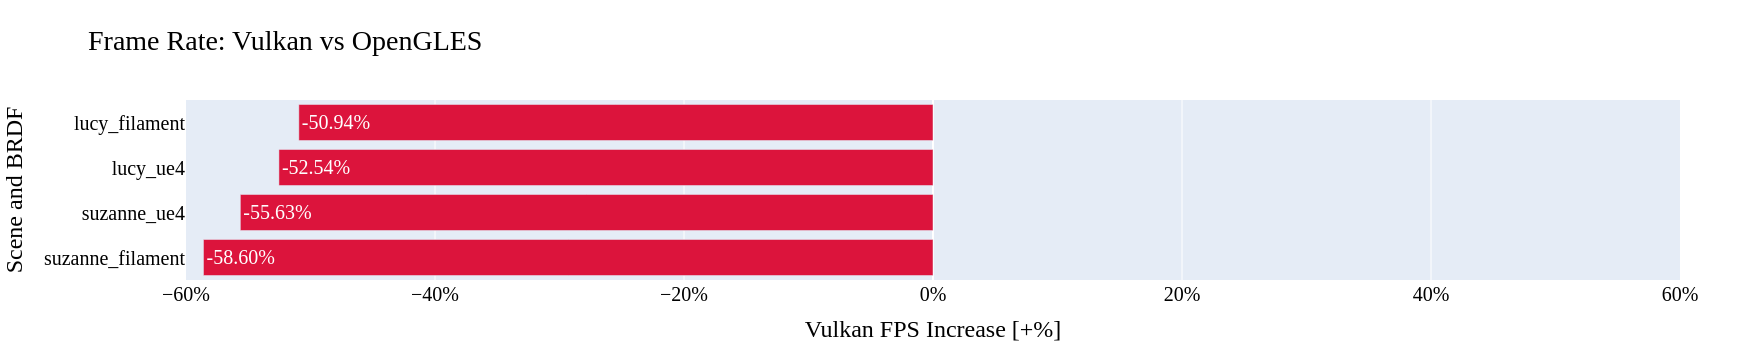

In [12]:
### Graphics API: Vulkan VS OpenGLES
### Frame-rate versus API
df_perf_vs = df_fps_10x.pivot_table(
    index = ["brdf", "scene"],
    columns = "api",
    values = "fps"
)

df_perf_vs["vk_vs_gles"] = df_perf_vs["vk"] / df_perf_vs["gles"] - 1
df_perf_vs = df_perf_vs["vk_vs_gles"].reset_index()
df_perf_vs["name"] = df_perf_vs["scene"] + "_" + df_perf_vs["brdf"]


fig = px.bar(df_perf_vs, x = "vk_vs_gles", y = "name", orientation='h',
            text_auto=".2%",
            title="Frame Rate: Vulkan vs OpenGLES",
            labels = {
                "vk_vs_gles": "Vulkan FPS Increase [+%]",
                "name": "Scene and BRDF",
            },
)
# COLOR
df_perf_vs["Color"] = np.where(df_perf_vs["vk_vs_gles"] > 0, 'green', 'crimson')
fig.update_traces(marker_color=df_perf_vs["Color"])

fig.update_layout(yaxis={'categoryorder':'total ascending'})
fig.update_layout(xaxis_range=[-0.6,0.6])
fig.update_layout(
    font=dict(
        family="FiraCode, Bold",
        size=20,  # Set the font size here
        color="black"
    )
)
fig.layout.xaxis.tickformat = ',.0%'

fig.write_image("plots/fps_api.png", scale=3)
fig.show()

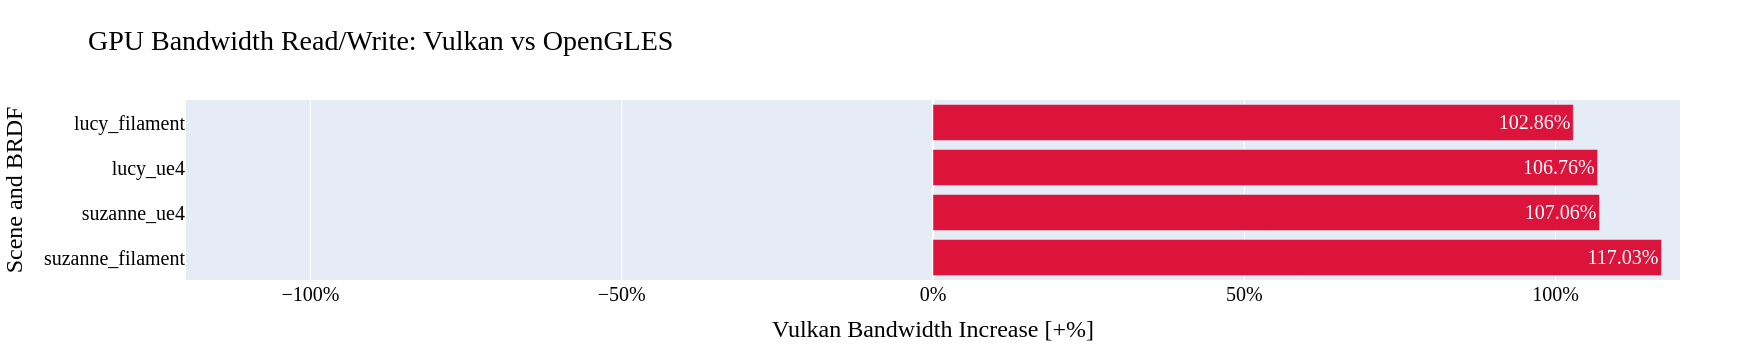

In [13]:
### Bandwidth versus API

df_bw_vs = df_bw_10x.pivot_table(
    index = ["brdf", "scene"],
    columns = "api",
    values = "bandwidth [MB/frame]"
)

df_bw_vs["vk_vs_gles"] = df_bw_vs["vk"] / df_bw_vs["gles"] - 1
df_bw_vs = df_bw_vs["vk_vs_gles"].reset_index()
df_bw_vs["name"] = df_bw_vs["scene"] + "_" + df_bw_vs["brdf"]

fig = px.bar(df_bw_vs, x = "vk_vs_gles", y = "name", orientation='h',
            text_auto=".2%",
            title="GPU Bandwidth Read/Write: Vulkan vs OpenGLES",
            labels = {
                "bandwidth [MB/frame]": "Bandwidth [MB / frame]",
                "name": "Scene and BRDF",
                "vk_vs_gles": "Vulkan Bandwidth Increase [+%]",
            },
)
# COLOR
df_bw_vs["Color"] = np.where(df_bw_vs["vk_vs_gles"] < 0, 'green', 'crimson')
fig.update_traces(marker_color=df_bw_vs["Color"])
fig.update_layout(xaxis_range=[-1.2,1.2])
fig.update_layout(
    font=dict(
        family="FiraCode, Bold",
        size=20,  # Set the font size here
        color="black"
    )
)
fig.layout.xaxis.tickformat = ',.0%'

fig.update_layout(yaxis={'categoryorder':'total descending'})
fig.write_image("plots/bw_api.png", scale=3)
fig.show()

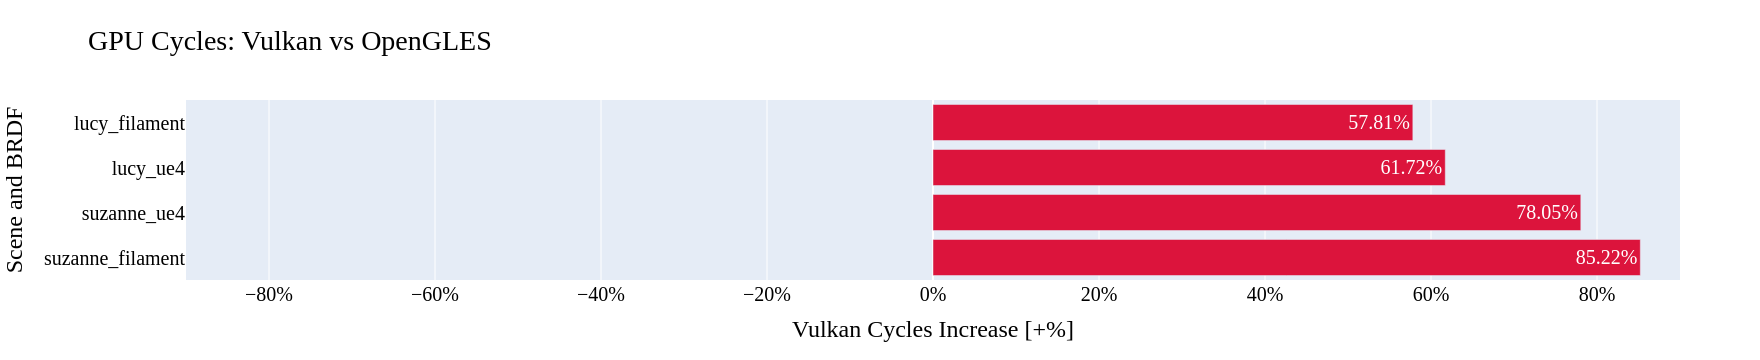

In [14]:
### Cycles versus API

df_cycles_vs = df_cycles_10x.pivot_table(
    index = ["brdf", "scene"],
    columns = "api",
    values = "Cycles / frame"
)

df_cycles_vs["vk_vs_gles"] = df_cycles_vs["vk"] / df_cycles_vs["gles"] - 1
df_cycles_vs = df_cycles_vs["vk_vs_gles"].reset_index()
df_cycles_vs["name"] = df_cycles_vs["scene"] + "_" + df_cycles_vs["brdf"]

fig = px.bar(df_cycles_vs, x = "vk_vs_gles", y = "name", orientation='h',
            text_auto=".2%",
            title="GPU Cycles: Vulkan vs OpenGLES",
            labels = {
                "bandwidth [MB/frame]": "Bandwidth [MB / frame]",
                "name": "Scene and BRDF",
                "vk_vs_gles": "Vulkan Cycles Increase [+%]",
            },
            )
# COLOR
df_cycles_vs["Color"] = np.where(df_cycles_vs["vk_vs_gles"] < 0, 'green', 'crimson')
fig.update_traces(marker_color=df_cycles_vs["Color"])
fig.update_layout(xaxis_range=[-0.9,0.9])
fig.update_layout(
    font=dict(
        family="FiraCode, Bold",
        size=20,  # Set the font size here
        color="black"
    )
)
fig.layout.xaxis.tickformat = ',.0%'

fig.update_layout(yaxis={'categoryorder':'total descending'}) 
fig.write_image("plots/cycles_api.png", scale=3)
fig.show()

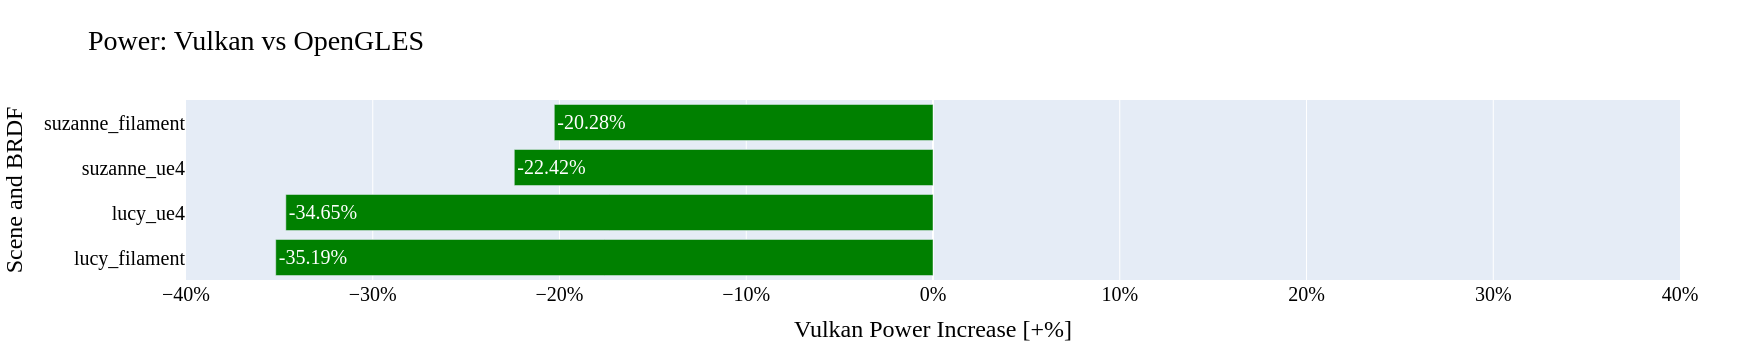

In [15]:
### Power versus API

df_power_vs = df_power_min_10x.pivot_table(
    index = ["brdf", "scene"],
    columns = "api",
    values = "Power [W]"
)

df_power_vs["vk_vs_gles"] = df_power_vs["vk"] / df_power_vs["gles"] - 1
df_power_vs = df_power_vs["vk_vs_gles"].reset_index()
df_power_vs["name"] = df_power_vs["scene"] + "_" + df_power_vs["brdf"]

fig = px.bar(df_power_vs, x = "vk_vs_gles", y = "name", orientation='h',
            text_auto=".2%",
            title="Power: Vulkan vs OpenGLES",
            labels = {
                "bandwidth [MB/frame]": "Bandwidth [MB / frame]",
                "name": "Scene and BRDF",
                "vk_vs_gles": "Vulkan Power Increase [+%]",
            },
            )
# COLOR
df_power_vs["Color"] = np.where(df_power_vs["vk_vs_gles"] < 0, 'green', 'crimson')
fig.update_traces(marker_color=df_power_vs["Color"])
fig.update_layout(xaxis_range=[-0.4,0.4])

fig.update_layout(
    font=dict(
        family="FiraCode, Bold",
        size=20,  # Set the font size here
        color="black"
    )
)
fig.layout.xaxis.tickformat = ',.0%'

fig.update_layout(yaxis={'categoryorder':'total ascending'}) 
fig.write_image("plots/power_api.png", scale=3)
fig.show()

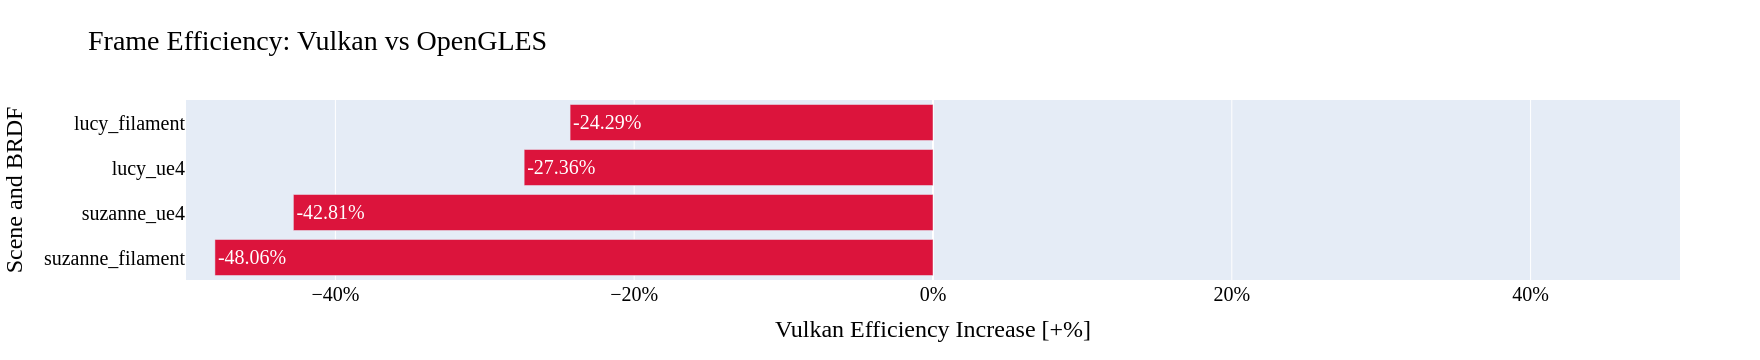

In [16]:
### Efficiency versus API
df_efficiency_vs = df_best_10x.loc[df_best_10x["variable"] == "Efficiency [FPS/W]"]
df_efficiency_vs = df_efficiency_vs.pivot_table(
    index = ["brdf", "scene"],
    columns = "api",
    values = "value"
)

df_efficiency_vs["vk_vs_gles"] = df_efficiency_vs["vk"] / df_efficiency_vs["gles"] - 1
df_efficiency_vs = df_efficiency_vs["vk_vs_gles"].reset_index()
df_efficiency_vs["name"] = df_efficiency_vs["scene"] + "_" + df_efficiency_vs["brdf"]

fig = px.bar(df_efficiency_vs, x = "vk_vs_gles", y = "name", orientation='h',
            text_auto=".2%",
            title="Frame Efficiency: Vulkan vs OpenGLES",
            labels = {
                "bandwidth [MB/frame]": "Bandwidth [MB / frame]",
                "name": "Scene and BRDF",
                "vk_vs_gles": "Vulkan Efficiency Increase [+%]",
            },
            )
# COLOR
df_efficiency_vs["Color"] = np.where(df_efficiency_vs["vk_vs_gles"] > 0, 'green', 'crimson')
fig.update_traces(marker_color=df_efficiency_vs["Color"])
fig.update_layout(xaxis_range=[-0.5,0.5])

fig.update_layout(
    font=dict(
        family="FiraCode, Bold",
        size=20,  # Set the font size here
        color="black"
    )
)
fig.layout.xaxis.tickformat = ',.0%'

fig.update_layout(yaxis={'categoryorder':'total ascending'}) 
fig.write_image("plots/efficiency_api.png", scale=3)
fig.show()

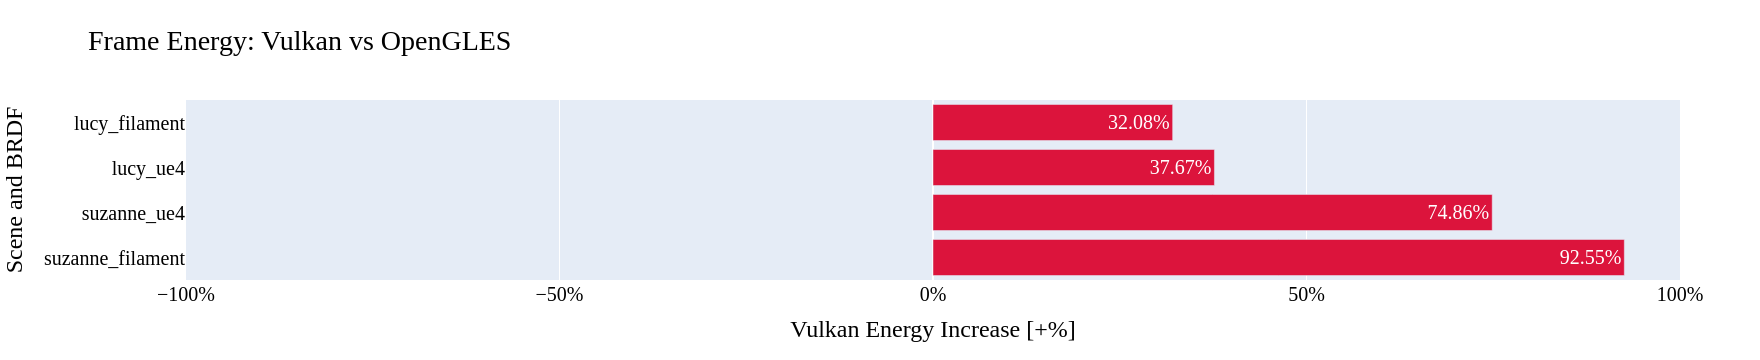

In [17]:
### Energy versus API
df_energy_vs = df_best_10x.loc[df_best_10x["variable"] == "Frame Energy [mJ/frame]"]
df_energy_vs = df_energy_vs.pivot_table(
    index = ["brdf", "scene"],
    columns = "api",
    values = "value"
)

df_energy_vs["vk_vs_gles"] = (df_energy_vs["vk"] / df_energy_vs["gles"]) - 1
df_energy_vs = df_energy_vs["vk_vs_gles"].reset_index()
df_energy_vs["name"] = df_energy_vs["scene"] + "_" + df_energy_vs["brdf"]

fig = px.bar(df_energy_vs, x = "vk_vs_gles", y = "name", orientation='h',
            text_auto=".2%",
            title="Frame Energy: Vulkan vs OpenGLES",
            labels = {
                "bandwidth [MB/frame]": "Bandwidth [MB / frame]",
                "name": "Scene and BRDF",
                "vk_vs_gles": "Vulkan Energy Increase [+%]",
            },
            )
# COLOR
df_energy_vs["Color"] = np.where(df_energy_vs["vk_vs_gles"] < 0, 'green', 'crimson')
fig.update_traces(marker_color=df_energy_vs["Color"])
fig.update_layout(xaxis_range=[-1,1])

fig.update_layout(
    font=dict(
        family="FiraCode, Bold",
        size=20,  # Set the font size here
        color="black"
    )
)
fig.layout.xaxis.tickformat = ',.0%'

fig.update_layout(yaxis={'categoryorder':'total descending'}) 
fig.write_image("plots/energy_api.png", scale=3)
fig.show()

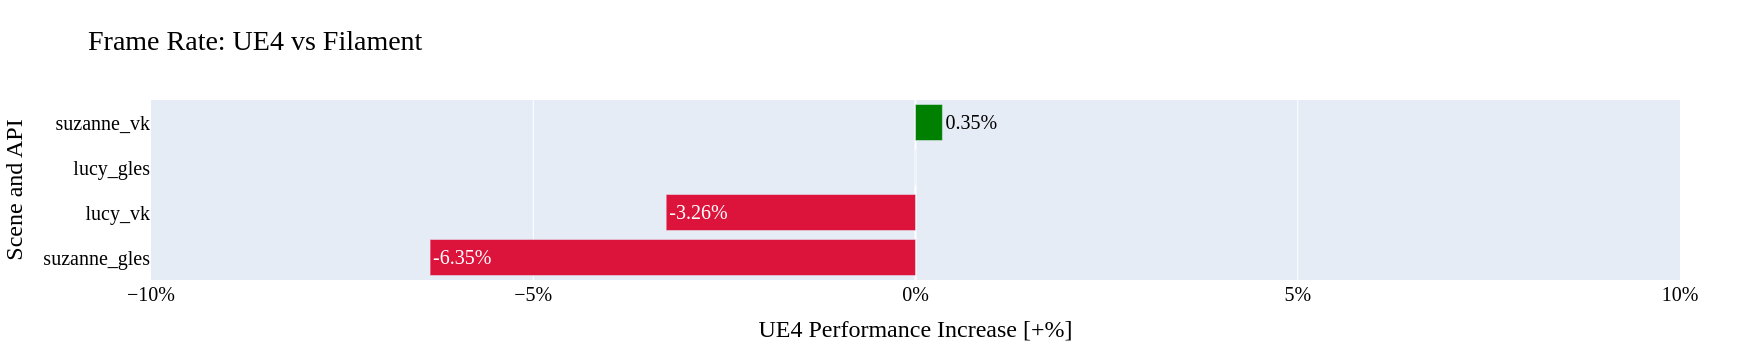

In [18]:
### BRDF comparisons
### Frame-rate versus BRDF
df_perf_vs = df_fps_10x.pivot_table(
    index = ["api", "scene"],
    columns = "brdf",
    values = "fps"
)

df_perf_vs["ue4_vs_filament"] = df_perf_vs["ue4"] / df_perf_vs["filament"] - 1
df_perf_vs = df_perf_vs["ue4_vs_filament"].reset_index()
df_perf_vs["name"] = df_perf_vs["scene"] + "_" + df_perf_vs["api"]

fig = px.bar(df_perf_vs, x = "ue4_vs_filament", y = "name", barmode="group", orientation='h',
            text_auto=".2%",
            title="Frame Rate: UE4 vs Filament",
            labels = {
                "vk_vs_gles": "Ratio",
                "name": "Scene and API",
                "ue4_vs_filament": "UE4 Performance Increase [+%]",
            },
)
df_perf_vs["Color"] = np.where(df_perf_vs["ue4_vs_filament"] > 0, 'green', 'crimson')
fig.update_traces(marker_color=df_perf_vs["Color"])
fig.update_layout(xaxis_range=[-0.1,0.1])

fig.update_layout(
    font=dict(
        family="FiraCode, Bold",
        size=20,  # Set the font size here
        color="black"
    )
)
fig.layout.xaxis.tickformat = ',.0%'

fig.update_layout(yaxis={'categoryorder':'total ascending'})
fig.write_image("plots/fps_brdf.png", scale=3)
fig.show()

In [19]:
### Bandwidth versus BRDF
df_bw_vs = df_bw_10x.pivot_table(
    index = ["api", "scene"],
    columns = "brdf",
    values = "bandwidth [MB/frame]"
)

df_bw_vs["ue4_vs_filament"] = df_bw_vs["ue4"] / df_bw_vs["filament"] - 1
df_bw_vs = df_bw_vs["ue4_vs_filament"].reset_index()
df_bw_vs["name"] = df_bw_vs["scene"] + "_" + df_bw_vs["api"]

fig = px.bar(df_bw_vs, x = "ue4_vs_filament", y = "name", orientation='h',
            # barmode="group", 
            text_auto=".2%",
            title="GPU Bandwidth Read/Write: UE4 vs Filament",
            labels = {
                "bandwidth [MB/frame]": "Bandwidth [MB / frame]",
                "name": "Scene and API",
                "ue4_vs_filament": "UE4 Bandwidth Increase [+%]",
            },
)
df_bw_vs["Color"] = np.where(df_bw_vs["ue4_vs_filament"] < 0, 'green', 'crimson')
fig.update_traces(marker_color=df_bw_vs["Color"])
fig.update_layout(xaxis_range=[-0.1,0.1])

fig.update_layout(
    font=dict(
        family="FiraCode, Bold",
        size=20,  # Set the font size here
        color="black"
    )
)
fig.layout.xaxis.tickformat = ',.0%'

fig.update_layout(yaxis={'categoryorder':'total descending'}) 
fig.write_image("plots/bw_brdf.png", scale=3)
fig.show()

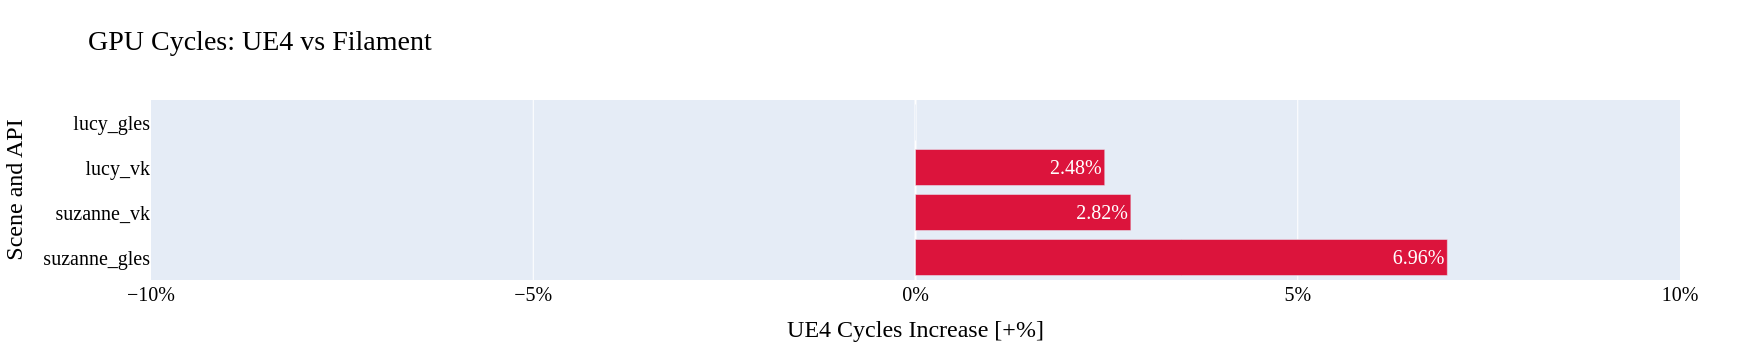

In [20]:
### Cycles versus BRDF
df_cycles_vs = df_cycles_10x.pivot_table(
    index = ["api", "scene"],
    columns = "brdf",
    values = "Cycles / frame"
)

df_cycles_vs["ue4_vs_filament"] = df_cycles_vs["ue4"] / df_cycles_vs["filament"] - 1
df_cycles_vs = df_cycles_vs["ue4_vs_filament"].reset_index()
df_cycles_vs["name"] = df_cycles_vs["scene"] + "_" + df_cycles_vs["api"]

fig = px.bar(df_cycles_vs, x = "ue4_vs_filament", y = "name", orientation='h',
            text_auto=".2%",
            title="GPU Cycles: UE4 vs Filament",
            labels = {
                "bandwidth [MB/frame]": "Bandwidth [MB / frame]",
                "name": "Scene and API",
                "ue4_vs_filament": "UE4 Cycles Increase [+%]",
            },
)
df_cycles_vs["Color"] = np.where(df_cycles_vs["ue4_vs_filament"] < 0, 'green', 'crimson')
fig.update_traces(marker_color=df_cycles_vs["Color"])
fig.update_layout(xaxis_range=[-0.1,0.1])

fig.update_layout(
    font=dict(
        family="FiraCode, Bold",
        size=20,  # Set the font size here
        color="black"
    )
)
fig.layout.xaxis.tickformat = ',.0%'

fig.update_layout(yaxis={'categoryorder':'total descending'}) 
fig.write_image("plots/cycles_brdf.png", scale=3)
fig.show()

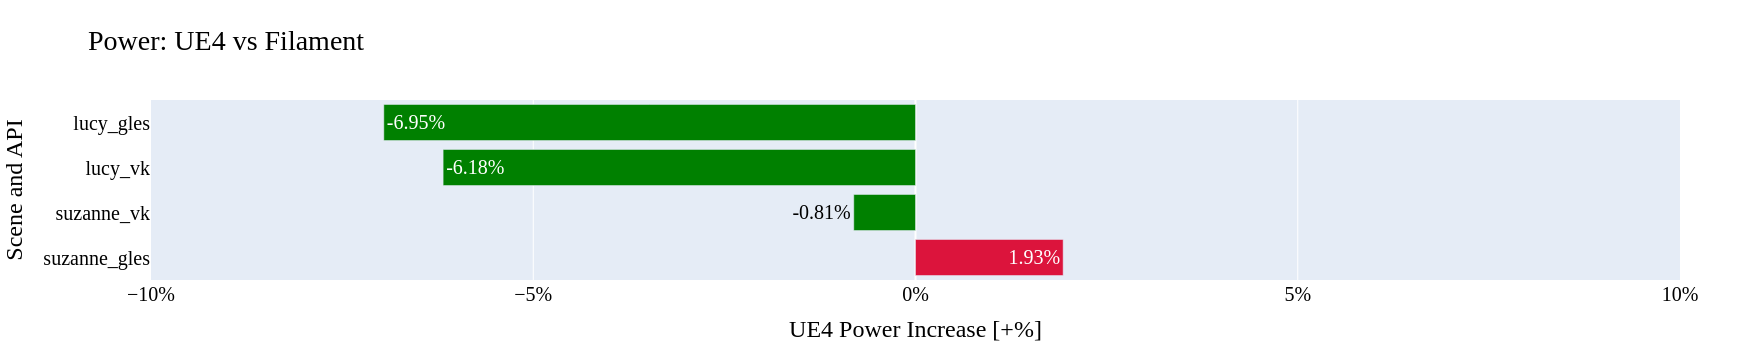

In [21]:
### Power versus BRDF
df_power_vs = df_power_min_10x.pivot_table(
    index = ["api", "scene"],
    columns = "brdf",
    values = "Power [W]"
)

df_power_vs["ue4_vs_filament"] = df_power_vs["ue4"] / df_power_vs["filament"] - 1
df_power_vs = df_power_vs["ue4_vs_filament"].reset_index()
df_power_vs["name"] = df_power_vs["scene"] + "_" + df_power_vs["api"]

fig = px.bar(df_power_vs, x = "ue4_vs_filament", y = "name", orientation='h',
            text_auto=".2%",
            title="Power: UE4 vs Filament",
            labels = {
                "bandwidth [MB/frame]": "Bandwidth [MB / frame]",
                "name": "Scene and API",
                "ue4_vs_filament": "UE4 Power Increase [+%]",
            },
)
# COLOR
df_power_vs["Color"] = np.where(df_power_vs["ue4_vs_filament"] < 0, 'green', 'crimson')
fig.update_traces(marker_color=df_power_vs["Color"])
fig.update_layout(xaxis_range=[-0.1,0.1])

fig.update_layout(
    font=dict(
        family="FiraCode, Bold",
        size=20,  # Set the font size here
        color="black"
    )
)
fig.layout.xaxis.tickformat = ',.0%'

fig.update_layout(yaxis={'categoryorder':'total descending'}) 
fig.write_image("plots/power_brdf.png", scale=3)
fig.show()

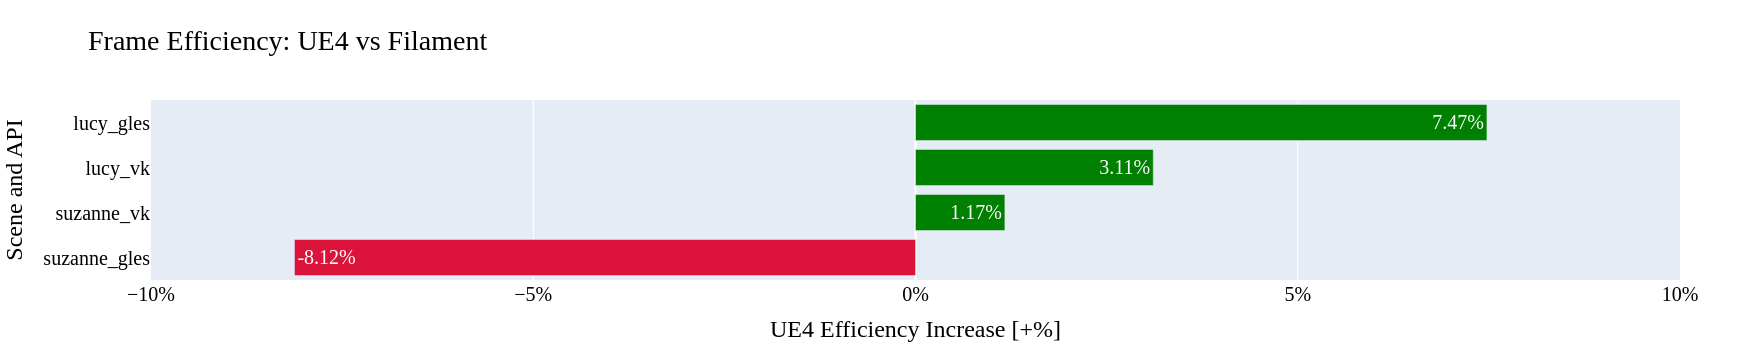

scene   api  ue4_vs_filament          name    Color
0     lucy  gles         0.074745     lucy_gles    green
1     lucy    vk         0.031102       lucy_vk    green
2  suzanne  gles        -0.081236  suzanne_gles  crimson
3  suzanne    vk         0.011691    suzanne_vk    green

In [22]:
### Efficiency versus BRDF
df_efficiency_brdf_vs = df_best_10x.loc[df_best_10x["variable"] == "Efficiency [FPS/W]"]
df_efficiency_brdf_vs = df_efficiency_brdf_vs.pivot_table(
    index = ["scene", "api"],
    columns = "brdf",
    values = "value"
)

df_efficiency_brdf_vs["ue4_vs_filament"] = df_efficiency_brdf_vs["ue4"] / df_efficiency_brdf_vs["filament"] - 1
df_efficiency_brdf_vs = df_efficiency_brdf_vs["ue4_vs_filament"].reset_index()
df_efficiency_brdf_vs["name"] = df_efficiency_brdf_vs["scene"] + "_" + df_efficiency_brdf_vs["api"]
df_efficiency_brdf_vs["Color"] = np.where(df_efficiency_brdf_vs["ue4_vs_filament"] > 0.000, 'green', 'crimson')

fig = px.bar(df_efficiency_brdf_vs, x = "ue4_vs_filament", y = "name", orientation='h',
            text_auto=".2%",
            title="Frame Efficiency: UE4 vs Filament",
            labels = {
                "bandwidth [MB/frame]": "Bandwidth [MB / frame]",
                "name": "Scene and API",
                "ue4_vs_filament": "UE4 Efficiency Increase [+%]",
            },
            )
# COLOR

fig.update_traces(marker_color=df_efficiency_brdf_vs["Color"])
fig.update_layout(xaxis_range=[-0.1,0.1])

fig.update_layout(
    font=dict(
        family="FiraCode, Bold",
        size=20,  # Set the font size here
        color="black"
    )
)
fig.layout.xaxis.tickformat = ',.0%'

fig.update_layout(yaxis={'categoryorder':'total ascending'}) 
fig.write_image("plots/efficiency_brdf.png", scale=3)
fig.show()
df_efficiency_brdf_vs


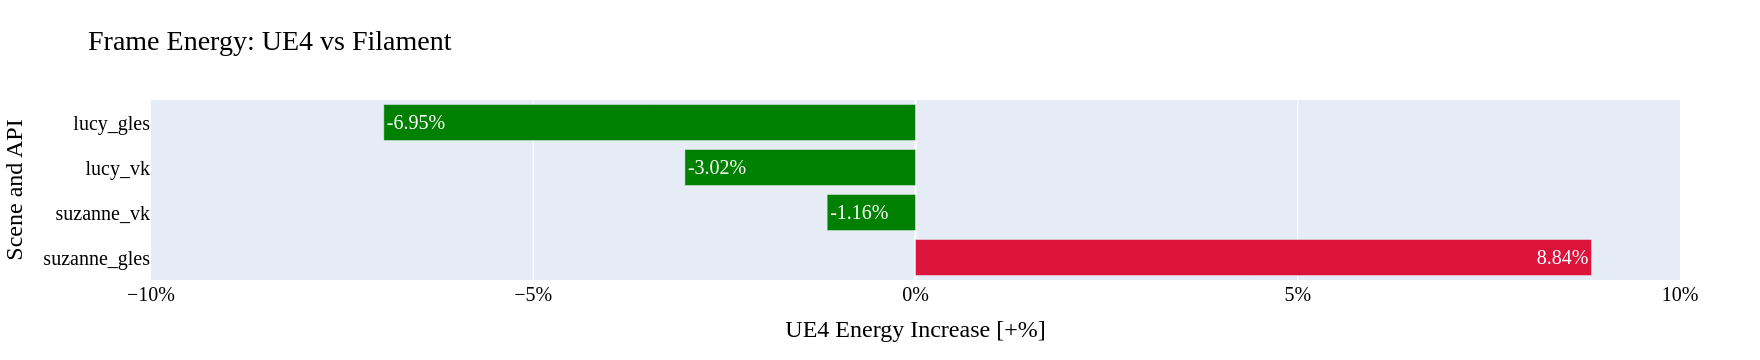

scene   api  ue4_vs_filament          name    Color
0     lucy  gles         0.074745     lucy_gles    green
1     lucy    vk         0.031102       lucy_vk    green
2  suzanne  gles        -0.081236  suzanne_gles  crimson
3  suzanne    vk         0.011691    suzanne_vk    green

In [23]:
### Energy versus BRDF
df_energy_brdf_vs = df_best_10x.loc[df_best_10x["variable"] == "Frame Energy [mJ/frame]"]
df_energy_brdf_vs = df_energy_brdf_vs.pivot_table(
    index = ["scene", "api"],
    columns = "brdf",
    values = "value"
)

df_energy_brdf_vs["ue4_vs_filament"] = df_energy_brdf_vs["ue4"] / df_energy_brdf_vs["filament"] - 1
df_energy_brdf_vs = df_energy_brdf_vs["ue4_vs_filament"].reset_index()
df_energy_brdf_vs["name"] = df_energy_brdf_vs["scene"] + "_" + df_energy_brdf_vs["api"]
df_energy_brdf_vs["Color"] = np.where(df_energy_brdf_vs["ue4_vs_filament"] > 0.000, 'green', 'crimson')

fig = px.bar(df_energy_brdf_vs, x = "ue4_vs_filament", y = "name", orientation='h',
            text_auto=".2%",
            title="Frame Energy: UE4 vs Filament",
            labels = {
                "bandwidth [MB/frame]": "Bandwidth [MB / frame]",
                "name": "Scene and API",
                "ue4_vs_filament": "UE4 Energy Increase [+%]",
            },
            )
# COLOR

fig.update_traces(marker_color=df_efficiency_brdf_vs["Color"])
fig.update_layout(xaxis_range=[-0.1,0.1])

fig.update_layout(
    font=dict(
        family="FiraCode, Bold",
        size=20,  # Set the font size here
        color="black"
    )
)
fig.layout.xaxis.tickformat = ',.0%'

fig.update_layout(yaxis={'categoryorder':'total descending'}) 
fig.write_image("plots/energy_brdf.png", scale=3)
fig.show()
df_efficiency_brdf_vs

In [24]:
### Scene: Suzanne vs Lucy

df_scene = df_best_10x
df_scene = df_scene.pivot_table(
    index = ["variable", "api", "brdf"],
    columns = "scene",
    values = "value"
).reset_index()

print(df_scene)

df_scene["suzanne_vs_lucy"] = df_scene["suzanne"] / df_scene["lucy"] - 1
df_scene["name"] = df_scene["api"] + "_" + df_scene["brdf"]
df_scene = df_scene.melt(
    id_vars = ["name", "api", "brdf", "variable"],      
)


scene                 variable   api      brdf          lucy       suzanne
0               Cycles / frame  gles  filament  1.280000e+07  1.150000e+07
1               Cycles / frame  gles       ue4  1.280000e+07  1.230000e+07
2               Cycles / frame    vk  filament  2.020000e+07  2.130000e+07
3               Cycles / frame    vk       ue4  2.070000e+07  2.190000e+07
4           Efficiency [FPS/W]  gles  filament  8.043823e+00  9.092893e+00
5           Efficiency [FPS/W]  gles       ue4  8.645060e+00  8.354219e+00
6           Efficiency [FPS/W]    vk  filament  6.089949e+00  4.722439e+00
7           Efficiency [FPS/W]    vk       ue4  6.279356e+00  4.777648e+00
8      Frame Energy [mJ/frame]  gles  filament  1.243190e+02  1.099760e+02
9      Frame Energy [mJ/frame]  gles       ue4  1.156730e+02  1.197000e+02
10     Frame Energy [mJ/frame]    vk  filament  1.642050e+02  2.117550e+02
11     Frame Energy [mJ/frame]    vk       ue4  1.592520e+02  2.093080e+02
12                   Powe

In [25]:
### Scene: Suzanne vs Lucy

df_scene = df_best_10x
df_scene = df_scene.pivot_table(
    index = ["variable", "api", "brdf"],
    columns = "scene",
    values = "value"
).reset_index()

df_scene["suzanne_vs_lucy"] = df_scene["suzanne"] / df_scene["lucy"] - 1
df_scene["name"] = df_scene["api"] + "_" + df_scene["brdf"]
df_scene = df_scene.melt(
    id_vars = ["name", "api", "brdf", "variable"],      
)

df_scene_vs = df_scene.loc[df_scene["scene"] == "suzanne_vs_lucy"]
df_scene_fps = df_scene_vs.loc[df_scene_vs["variable"] == "fps"]
df_scene_bw = df_scene_vs.loc[df_scene_vs["variable"] == "bandwidth [MB/frame]"]
df_scene_cycles = df_scene_vs.loc[df_scene_vs["variable"] == "Cycles / frame"]
df_scene_power = df_scene_vs.loc[df_scene_vs["variable"] == "Power [W]"]
df_scene_efficiency = df_scene_vs.loc[df_scene_vs["variable"] == "Efficiency [FPS/W]"]
df_scene_energy = df_scene_vs.loc[df_scene_vs["variable"] == "Frame Energy [mJ/frame]"]

/tmp/ipykernel_56890/2216614780.py:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



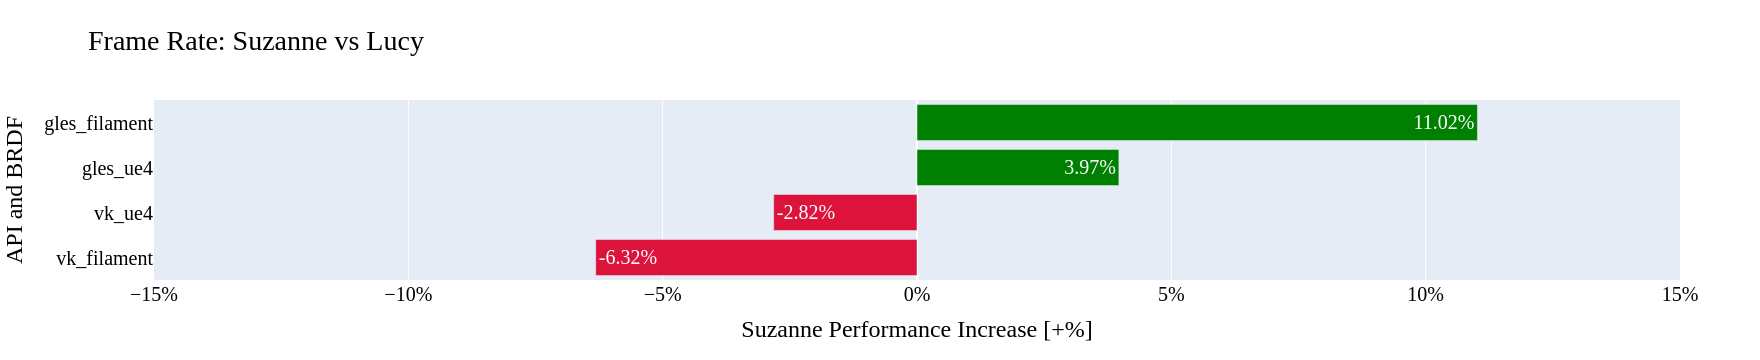

In [26]:
fig = px.bar(df_scene_fps, x = "value", y = "name",  text_auto=".2%", orientation='h',
            title="Frame Rate: Suzanne vs Lucy",
            labels = {
                "bandwidth [MB/frame]": "Bandwidth [MB / frame]",
                "name": "API and BRDF",
                "value": "Suzanne Performance Increase [+%]",
            },
)

fig.update_layout(xaxis_range=[-0.15,0.15])

df_scene_fps["Color"] = np.where(df_scene_fps["value"] > 0, 'green', 'crimson')
fig.update_traces(marker_color=df_scene_fps["Color"])
fig.layout.xaxis.tickformat = ',.0%'
fig.update_layout(yaxis={'categoryorder':'total ascending'}) 
fig.update_layout(
    font=dict(
        family="FiraCode, Bold",
        size=20,  # Set the font size here
        color="black"
    )
)
fig.write_image("plots/scene_fps.png", scale=3)
fig.show()

/tmp/ipykernel_56890/388424341.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



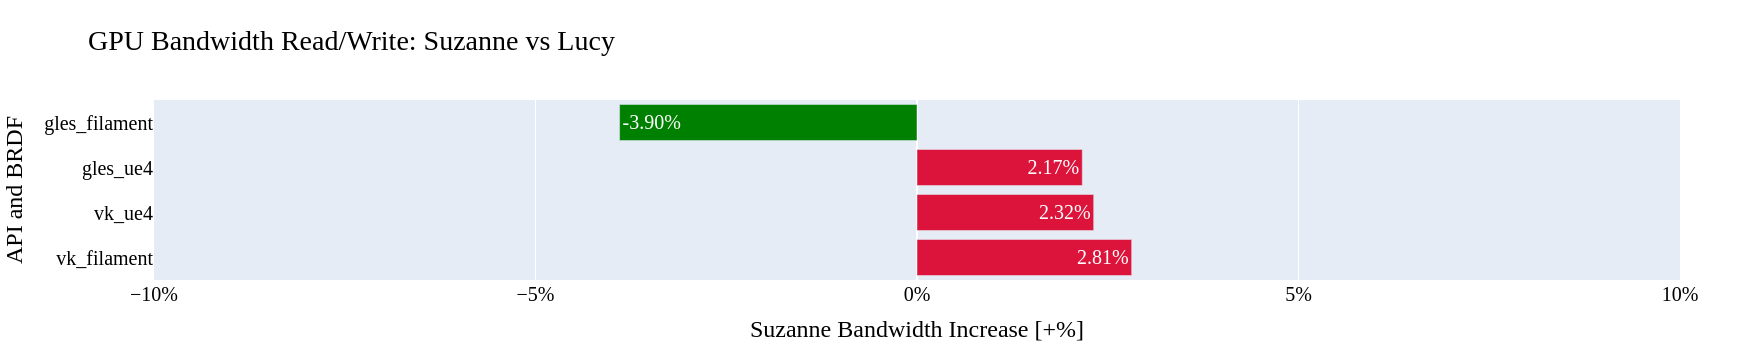

In [27]:
fig = px.bar(df_scene_bw, x = "value", y = "name", barmode="group", text_auto=".2%", orientation='h',
            title="GPU Bandwidth Read/Write: Suzanne vs Lucy",
            labels = {
                "bandwidth [MB/frame]": "Bandwidth [MB / frame]",
                "name": "API and BRDF",
                "value": "Suzanne Bandwidth Increase [+%]",
            },
)

df_scene_bw["Color"] = np.where(df_scene_bw["value"] < 0, 'green', 'crimson')
fig.update_traces(marker_color=df_scene_bw["Color"])
fig.update_layout(
    font=dict(
        family="FiraCode, Bold",
        size=20,  # Set the font size here
        color="black"
    )
)
fig.update_layout(xaxis_range=[-0.1,0.1])
fig.layout.xaxis.tickformat = ',.0%'

fig.update_layout(yaxis={'categoryorder':'total descending'}) 
fig.write_image("plots/scene_bw.png", scale=3)
fig.show()

/tmp/ipykernel_56890/1054153724.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



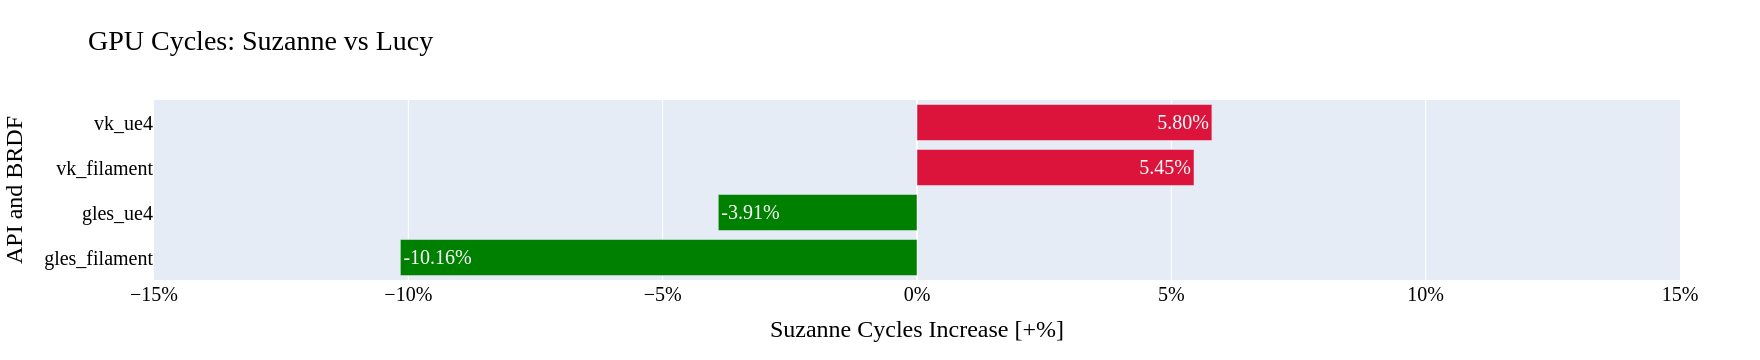

In [28]:
fig = px.bar(df_scene_cycles, x = "value", y = "name", barmode="group", text_auto=".2%", orientation='h',
            title="GPU Cycles: Suzanne vs Lucy",
            labels = {
                "bandwidth [MB/frame]": "Bandwidth [MB / frame]",
                "name": "API and BRDF",
                "value": "Suzanne Cycles Increase [+%]",
            },
)

df_scene_cycles["Color"] = np.where(df_scene_cycles["value"] < 0, 'green', 'crimson')
fig.update_traces(marker_color=df_scene_cycles["Color"])
fig.update_layout(
    font=dict(
        family="FiraCode, Bold",
        size=20,  # Set the font size here
        color="black"
    )
)
fig.update_layout(xaxis_range=[-0.15,0.15])
fig.layout.xaxis.tickformat = ',.0%'

fig.update_layout(xaxis={'categoryorder':'total ascending'}) 
fig.write_image("plots/scene_cycles.png", scale=3)
fig.show()

/tmp/ipykernel_56890/2769411180.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



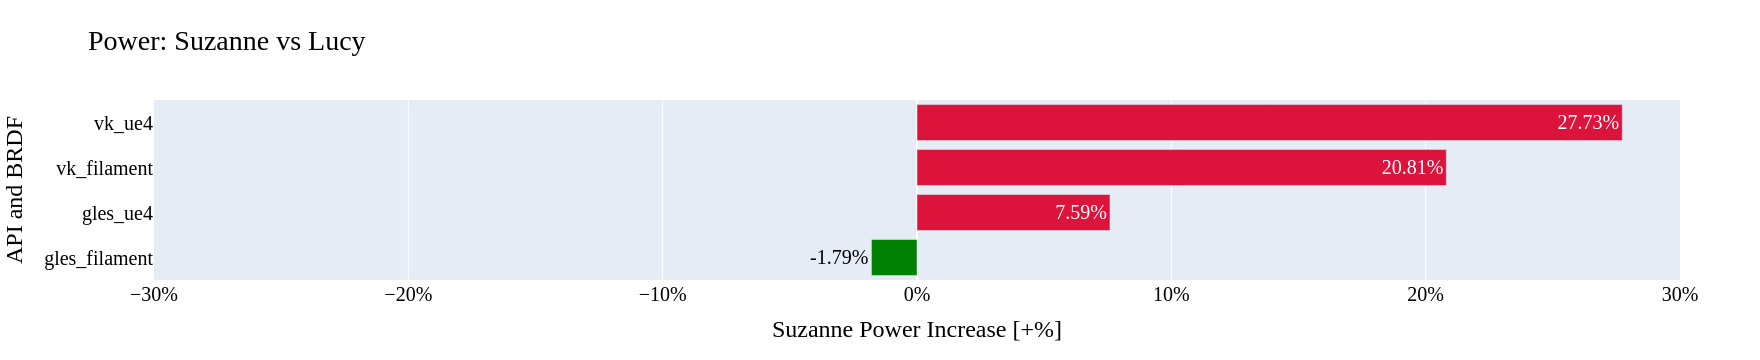

In [29]:
fig = px.bar(df_scene_power, x = "value", y = "name", barmode="group", text_auto=".2%", orientation='h',
            title="Power: Suzanne vs Lucy",
            labels = {
                "bandwidth [MB/frame]": "Bandwidth [MB / frame]",
                "name": "API and BRDF",
                "value": "Suzanne Power Increase [+%]",
            },
)

df_scene_power["Color"] = np.where(df_scene_power["value"] < 0, 'green', 'crimson')
fig.update_traces(marker_color=df_scene_power["Color"])
fig.update_layout(
    font=dict(
        family="FiraCode, Bold",
        size=20,  # Set the font size here
        color="black"
    )
)
fig.update_layout(xaxis_range=[-0.3,0.3])
fig.layout.xaxis.tickformat = ',.0%'

fig.update_layout(xaxis={'categoryorder':'total ascending'}) 
fig.write_image("plots/scene_power.png", scale=3)
fig.show()

/tmp/ipykernel_56890/3875734286.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



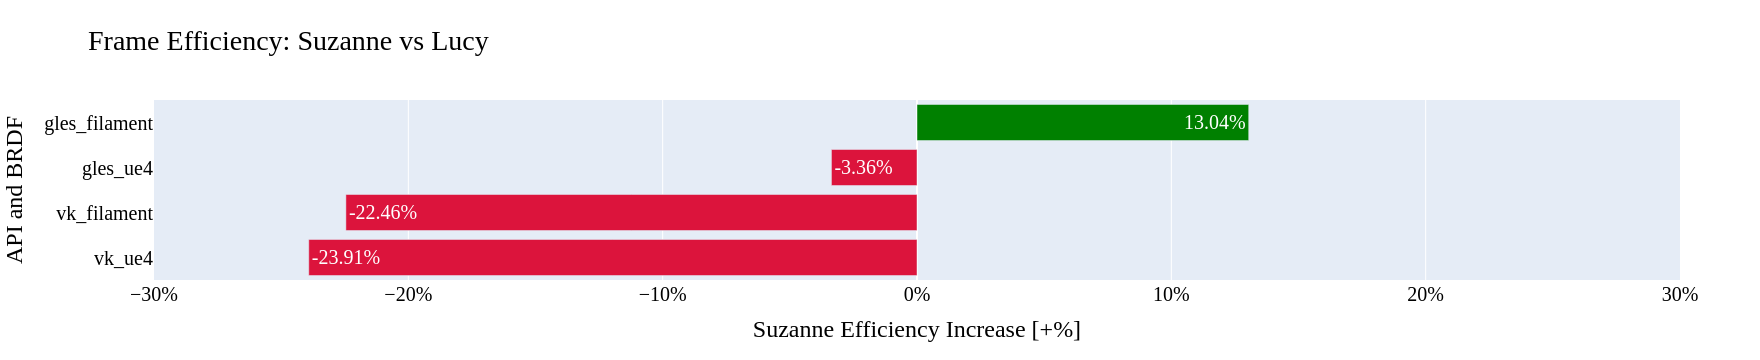

In [30]:
fig = px.bar(df_scene_efficiency, x = "value", y = "name", barmode="group", text_auto=".2%", orientation='h',
            title="Frame Efficiency: Suzanne vs Lucy",
            labels = {
                "bandwidth [MB/frame]": "Bandwidth [MB / frame]",
                "name": "API and BRDF",
                "value": "Suzanne Efficiency Increase [+%]",
            },
)

df_scene_efficiency["Color"] = np.where(df_scene_efficiency["value"] > 0, 'green', 'crimson')
fig.update_traces(marker_color=df_scene_efficiency["Color"])
fig.update_layout(
    font=dict(
        family="FiraCode, Bold",
        size=20,  # Set the font size here
        color="black"
    )
)

fig.update_layout(xaxis_range=[-0.3,0.3])
fig.layout.xaxis.tickformat = ',.0%'

fig.update_layout(yaxis={'categoryorder':'total ascending'}) 
fig.write_image("plots/scene_efficiency.png", scale=3)
fig.show()

/tmp/ipykernel_56890/931962571.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



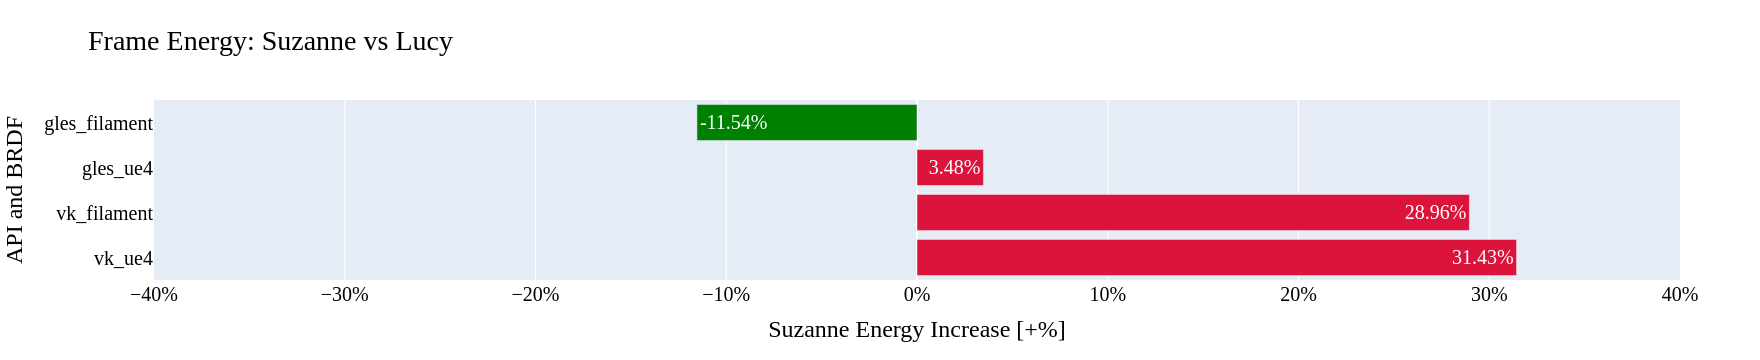

In [31]:
fig = px.bar(df_scene_energy, x = "value", y = "name", barmode="group", text_auto=".2%", orientation='h',
            title="Frame Energy: Suzanne vs Lucy",
            labels = {
                "bandwidth [MB/frame]": "Bandwidth [MB / frame]",
                "name": "API and BRDF",
                "value": "Suzanne Energy Increase [+%]",
            },
)

df_scene_efficiency["Color"] = np.where(df_scene_efficiency["value"] > 0, 'green', 'crimson')
fig.update_traces(marker_color=df_scene_efficiency["Color"])
fig.update_layout(
    font=dict(
        family="FiraCode, Bold",
        size=20,  # Set the font size here
        color="black"
    )
)

fig.update_layout(xaxis_range=[-0.4,0.4])
fig.layout.xaxis.tickformat = ',.0%'

fig.update_layout(yaxis={'categoryorder':'total descending'}) 
fig.write_image("plots/scene_energy.png", scale=3)
fig.show()